# Beam Waist Measurements

**Scott Prahl**

**Mar 2021**

This notebook starts to introduce basic ideas about a Gaussian beam waist.  One set of beam data is selected and fit by eye.  This is obviously not in compliance with ISO 11146, but it does give one a sense of how sensitive the beam parameters are to the fitting process.

---
*If* `` laserbeamsize `` *is not installed, uncomment the following cell (i.e., delete the initial #) and execute it with* `` shift-enter ``.  *Afterwards, you may need to restart the kernel/runtime before the module will import successfully.*

In [1]:
#!pip install --user laserbeamsize

In [2]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

try:
    import laserbeamsize as lbs

except ModuleNotFoundError:
    print('laserbeamsize is not installed. To install, uncomment and run the cell above.')
    print('Once installation is successful, rerun this cell again.')

pixel_size_µm = 3.75
repo = "https://github.com/scottprahl/laserbeamsize/raw/master/docs/"

## Gaussian Beam Propagation

It would seem that $w$ should stand for *width*, but it doesn't.  This means that $w$ is not the diameter but the radius.  Go figure.

### Beam waist 

In any case, the minimum beam radius as a Gaussian beam propagates is called $w_0$ and is located at $z_0$.  This is shown graphically below.

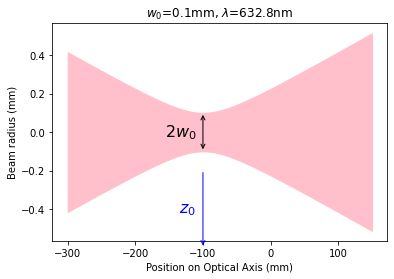

In [3]:
w0=0.1                    # radius of beam waist [mm]
z0=-100                   # z-axis position of beam waist [mm]
lambda0=0.6328/1000       # again in mm
zR=lbs.z_rayleigh(w0,lambda0) # Rayleigh Distance

z = np.linspace(-300,150,100)

r = lbs.beam_radius(w0, lambda0, z, z0=z0)
plt.fill_between(z,-r,r,color='pink')

plt.xlabel("Position on Optical Axis (mm)")
plt.ylabel("Beam radius (mm)")
plt.title("$w_0$=%.1fmm, $\lambda$=%.1fnm"%(w0,1e6*lambda0))
plt.annotate('$2w_0$',xy=(z0-10,0),ha='right',va='center', fontsize=16)
plt.annotate('',xy=(z0,w0),xytext=(z0,-w0),arrowprops=dict(arrowstyle="<->"))

plt.annotate('$z_0$',xy=(z0-10,-0.4),ha='right',va='center', fontsize=16,color='blue')
plt.annotate('',xy=(z0,-0.2),xytext=(z0,-0.6),arrowprops=dict(arrowstyle="<-",color='blue'))
#plt.ylim(-0.5,0.5)

plt.show()

### Rayleigh Length

The Rayleigh length $z_R$ is

$$
z_R= \frac{\pi w_0^2}{\lambda M^2}
$$

and is the distance from the beam waist to the point where the beam radius has increased by a factor of $\sqrt{2}$ (and therefore the area has doubled or the irradiance (power/area) has dropped 50%).  It also happens to be the location of the greatest curvature (the beam is flat at the focus and flat at infinity, it must have a maximum somewhere.)

### Beam Radius

The function $w(z)$ is the beam radius as a function of location $z$ along the axis. As seen above, when $z = z_0$ it reaches a minimum value $w_0$, called the beam waist. For a Gaussian beam propagating in free space, the beam radius at any point only depends on the waist $w_0$, its location $z_0$, and the wavelength.

$$
w(z)=w_0\sqrt{1+\left(\frac{z-z_0}{z_R}\right)^2}
$$

The beam waist $w_0$ and its location at $z = z_0$ determine the beam size everywhere (assuming, of course, that the wavelength is known).

### Beam Divergence $\theta$

The half beam divergence is defined as

$$
\theta=\lim_{z\rightarrow\infty}\frac{w(z)}{z}={w_0\over z_R}
$$

The full beam divergence is denoted by a capital theta

$$
\Theta=\lim_{z\rightarrow\infty}\frac{d(z)}{z}=\lim_{z\rightarrow\infty}\frac{2w(z)}{z}={2w_0\over z_R}
$$


The beam divergence and Rayleigh lengths are shown in the graph below.

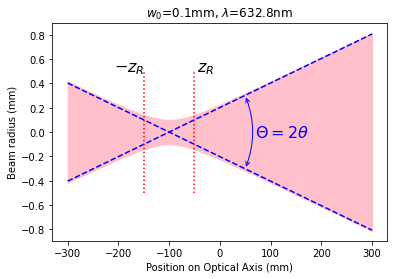

In [4]:
w0=0.1                    # radius of beam waist [mm]
z0=-100                   # z-axis position of beam waist [mm]
lambda0=0.6328/1000       # again in mm
zR=lbs.z_rayleigh(w0,lambda0) # Rayleigh Distance

theta = w0/zR
z = np.linspace(-300,300,100)
r = lbs.beam_radius(w0, lambda0, z, z0=z0)
plt.fill_between(z, -r, r, color='pink')

plt.plot(z,theta*(z-z0),'--b')
plt.plot(z,-theta*(z-z0),'--b')
plt.plot([zR+z0,zR+z0],[-1/2,1/2],':r')
plt.plot([-zR+z0,-zR+z0],[-1/2,1/2],':r')

plt.xlabel("Position on Optical Axis (mm)")
plt.ylabel("Beam radius (mm)")
plt.title("$w_0$=%.1fmm, $\lambda$=%.1fnm"%(w0,1e6*lambda0))
plt.annotate('$z_R$',xy=(0.9*(zR+z0),0.5),fontsize=16)
plt.annotate('$-z_R$',xy=(1.4*(-zR+z0),0.5),fontsize=16)

plt.annotate(r'$\Theta=2\theta$',xy=(70,0),fontsize=16,va='center',color='blue')
plt.annotate('',xy=(50,0.30),xytext=(50,-0.30),arrowprops=dict(connectionstyle="arc3,rad=0.2", arrowstyle="<->",color='blue'))

plt.show()

## Experimentally determining beam parameters

Test with 12 different images of the beam taken at different axial positions. 

First, load the images and find the beam diameters dx and dy.

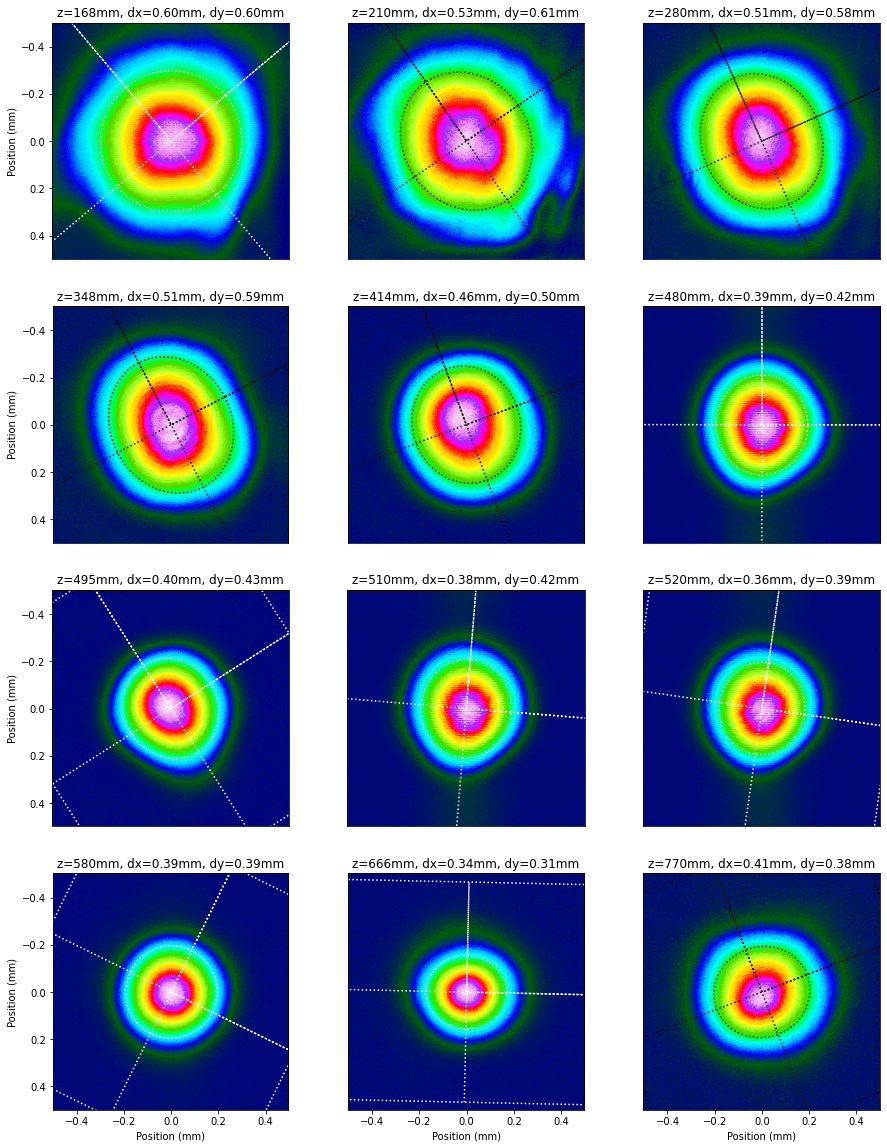

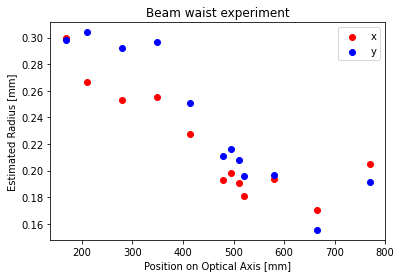

In [5]:
# array of distances at which images were collected
z1 = np.array([168,210,280,348,414,480,495,510,520,580,666,770],dtype=float) #mm

# array of filenames associated with each image
fn1 = [repo + "t-%dmm.pgm" % number for number in z1]

# read them all into memory 
test_img = [imageio.imread(fn) for fn in fn1]
dx,dy=lbs.beam_size_montage(test_img, z=z1*1e-3, pixel_size=pixel_size_µm/1000, units='mm', crop=[1,1])
plt.show()

rx = dx/2
ry = dy/2 

plt.scatter(z1, rx, color='red', label='x')
plt.scatter(z1, ry, color='blue', label='y')

plt.xlabel('Position on Optical Axis [mm]')
plt.ylabel('Estimated Radius [mm]')
plt.title("Beam waist experiment")
plt.legend()
plt.show()

Fit the data to theory by hand.  Best practice is to make measurements at positions more than two Rayleigh distances from the beam waist.  This data does not have those points a fit of the data leads to unphysical (impossible) values for M².  More on this in a later notebook.

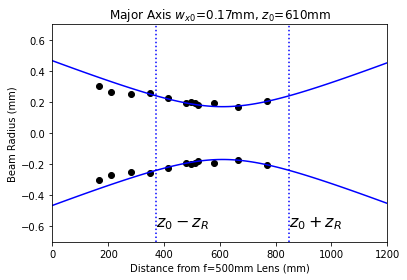

In [6]:
# Need array of data so we can plot theory
z = np.linspace(0,1200,100)          #mm

lambda0 = 632.8e-6  #mm

# these three parameters are changed until the fit looks reasonable
# the M² value is obviously not possible
z0 = 610   #mm
w0 = 0.17  #mm
M2 = 0.6

zR = lbs.z_rayleigh(w0, lambda0, M2=M2)

plt.scatter(z1, rx, color='black')
plt.scatter(z1,-rx, color='black')

r =  lbs.beam_radius(w0, lambda0, z, z0=z0, M2=M2)       

plt.plot(z,r,color='blue')
plt.plot(z,-r,color='blue')

plt.axvline(z0+zR, color='blue', linestyle=':')
plt.axvline(z0-zR, color='blue', linestyle=':')

plt.xlabel("Distance from f=500mm Lens (mm)")
plt.ylabel("Beam Radius (mm)")
plt.title("Major Axis $w_{x0}$=%.2fmm, $z_0$=%.0fmm"%(w0,z0))
plt.text(z0-zR, -0.6, '$z_0-z_R$', fontsize=16)
plt.text(z0+zR, -0.6, '$z_0+z_R$',  fontsize=16)

plt.xlim(0,1200)
plt.ylim(-0.7,0.7)
plt.show()
